# Import Libraries

#### Modeling and Modeling Metrics Libraries 

In [1]:
# Models and Transformers
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import LinearRegression, LogisticRegression

# Model Metrics
from sklearn.metrics import PrecisionRecallDisplay, RocCurveDisplay, f1_score, confusion_matrix
from sklearn import metrics

# Optimization
from sklearn.model_selection import GridSearchCV

#### (Auto)correlation

In [2]:
from pandas.plotting import autocorrelation_plot

#### Data Visualization

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

#### File Management

In [4]:
import os
import subprocess
import glob
import pickle

#### NLP & Text Parsing

In [5]:
import re
from textblob import TextBlob

In [6]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

#### Pandas/NumPy/Datetime

In [7]:
import pandas as pd
import numpy as np

from datetime import datetime, date, time

#### Twitter/Stock Data Scraper

In [8]:
import snscrape.modules.twitter as sntwitter
import yfinance as yf

# Custom Functions

In [9]:
# Get Twitter Data (Saved as csv on local machine)

def scrapeTweets(start_date, end_date, keyword, current_dir, tweet_limit=1, iteration=0):
    if not os.path.exists(current_dir):  # Creates directory in current directory if doesn't already exist
        os.mkdir(current_dir)

    file_path = os.path.join(current_dir, f'keyword:{keyword}__start:{start_date}_end:{end_date}__iter:{iteration}.csv')

    tweet_list = []
    for i, tweet in enumerate(
            sntwitter.TwitterSearchScraper(f'{keyword} since:{start_date} until:{end_date}').get_items()):
        if i > tweet_limit:
            break
        tweet_list.append([tweet.date,  # Appending all tweet data into a list of list
                           tweet.id,
                           tweet.content,
                           tweet.user.username,
                           tweet.user.followersCount,
                           tweet.lang,
                           tweet.retweetCount,
                           tweet.likeCount,
                           tweet.replyCount])

    df_tweets = pd.DataFrame(tweet_list, columns=['Datetime',  # Creating df of tweet data
                                                  'Tweet Id',
                                                  'Text',
                                                  'Username',
                                                  'Followers Count',
                                                  'Language',
                                                  'Retweet Count',
                                                  'Likes Count',
                                                  'Reply Count'])

    for i in range(1001):
        if not os.path.isfile(file_path):
            df_tweets.to_csv(file_path, index=False)
            break
        else:
            file_path = os.path.join(current_dir,
                                     f'keyword:{keyword}__start:{start_date}_end:{end_date}__limit:{tweet_limit}__iter:{i + 1}.csv')

    if os.path.isfile(file_path):
        return print(f'Successfully saved DataFrame to {file_path}')
    return print('DataFrame not saved -- possible error has occurred.')

In [10]:
def dataWrangle_single(dataframe):   
    df_filter = dataframe[dataframe['Language'] == 'en'][['Datetime', # Filter via Language = 'en'
                                                           'Tweet Id', # Remove unwanted columns
                                                           'Text', 
                                                           'Username',
                                                           'Followers Count',
                                                           'Retweet Count',
                                                           'Likes Count',
                                                           'Reply Count']] 
    df_clean = df_filter.astype({'Tweet Id':str})\
                        .dropna()\
                        .drop_duplicates()\
                        .reset_index(drop=True)
    
    df_clean['Text'] = (df_clean['Text'] # Cleans out redundant string characters within each tweet
                       .apply(lambda x: ' '.join(re.sub(r'https\S+', '', x)
                                                .replace('\n', ' ')
                                                .split()
                                                )
                             )
                       )
    
    df_clean['Datetime'] = pd.to_datetime(df_clean['Datetime']).dt.floor('d').dt.tz_localize(tz=None)
    
    return df_clean.set_index('Datetime').sort_index()

In [11]:
# Wrangle Tweet Data

def dataWrangle_multiple(dataframe_list):   
    df_concat = pd.concat(dataframe_list) # Concatenate all the DataFrames from the list of DataFrames
    df_filter = df_concat[df_concat['Language'] == 'en'][['Datetime', # Filter via Language = 'en'
                                                           'Tweet Id', # Remove unwanted columns
                                                           'Text', 
                                                           'Username',
                                                           'Followers Count',
                                                           'Retweet Count',
                                                           'Likes Count',
                                                           'Reply Count']] 
    df_clean = df_filter.astype({'Tweet Id':str})\
                        .dropna()\
                        .drop_duplicates()\
                        .reset_index(drop=True)
    
    df_clean['Text'] = (df_clean['Text'] # Cleans out redundant string characters within each tweet
                       .apply(lambda x: ' '.join(re.sub(r'https\S+', '', x)
                                                .replace('\n', ' ')
                                                .split()
                                                )
                             )
                       )
    
    df_clean['Datetime'] = pd.to_datetime(df_clean['Datetime']).dt.floor('d').dt.tz_localize(tz=None)
    
    return df_clean.set_index('Datetime').sort_index()
                                               

In [12]:
# Get Stock Data (DataFrame)

def getStockData(ticker, start, end):
    df_stock = yf.download(ticker, start, end)
    df_stock.index = df_stock.index.tz_localize(tz=None).rename(name='Datetime')
    df_stock['Closing Differences'] = df_stock['Adj Close'].diff()
    df_stock['Percent Change'] = ((df_stock['Close']-df_stock['Open'])/df_stock['Open'])*100
    
    return df_stock    

In [13]:
# CLASSIFICATION Model Evaluation

def model_evaluation(model, X, y_true, positive_label):
    y_pred = model.predict(X)
    scores = {}
    scores['accuracy'] = round(metrics.accuracy_score(y_true, y_pred), 4)
    scores['precision'] = round(metrics.precision_score(y_true, y_pred, pos_label=positive_label), 4)
    scores['recall'] = round(metrics.recall_score(y_true, y_pred, pos_label=positive_label), 4)
    probs = model.predict_proba(X).T[1]
    precisions, recalls, thresholds = metrics.precision_recall_curve(y_true, probs, pos_label=positive_label)
    scores['area under precision-recall curve'] = round(metrics.auc(recalls, precisions), 4)
    scores['f1 score'] = round(f1_score(y_true=y_true, y_pred=y_pred, pos_label= "Positive_Trend"), 4)
    return scores

def print_model_evaluation(model_name, scores):
#     print('{} evaluation \n'.format(model_name))
    for metric, score in scores.items():
        print('Test {}: {}'.format(metric, score))


In [14]:
# 1. Polarity Score Categories as a column on DataFrame
# 2. Creating categorical polarity column

def polarityCategories_textblob(tup):
    if tup[0] < -0.05:
        return 'Negative'
    elif tup[0] > 0.05:
        return 'Positive'
    else:
        return 'Neutral'
    
def polarityColumns_textblob(df_tweets):
    df_tweets['Polarity/Subjectivity Scores'] = df_tweets['Text'].apply(lambda text: TextBlob(text).sentiment)
    df_tweets_filtered = df_tweets[df_tweets['Polarity/Subjectivity Scores'] != (0.0,0.0)]
    df_tweets_filtered = df_tweets_filtered.copy()
    df_tweets_filtered['Polarity Categories'] = df_tweets_filtered['Polarity/Subjectivity Scores'].apply(lambda x: polarityCategories(x))
    
    print(df_tweets_filtered.value_counts('Polarity Categories'))
    
    return df_tweets_filtered

In [15]:
def polarityCategories_vader(tup):
    if tup[0] < -0.05:
        return 'Negative'
    elif tup[0] > 0.05:
        return 'Positive'
    else:
        return 'Neutral'
    
def polarityColumns_vader(df_tweets):
    df_tweets['Sentiment'] = df_tweets['Text'].apply(lambda text: SentimentIntensityAnalyzer().polarity_scores(text))
#     df_tweets_filtered = df_tweets_filtered.copy()
#     df_tweets_filtered['Polarity Categories'] = df_tweets_filtered['Polarity/Subjectivity Scores'].apply(lambda x: polarityCategories_vader(x))
    
#     print(df_tweets_filtered.value_counts('Polarity Categories'))
    
    return df_tweets

In [16]:
def assign_score_columns(df):
    df['Positive Tweet Score'] = df['Sentiment'].apply(lambda scores: scores['pos'])
    df['Negative Tweet Score'] = df['Sentiment'].apply(lambda scores: scores['neg'])
    df['Neutral Tweet Score'] = df['Sentiment'].apply(lambda scores: scores['neu'])
    df['Compound Tweet Score'] = df['Sentiment'].apply(lambda scores: scores['compound'])
    
    df = df[df['Compound Tweet Score'] != 0.0]
    return df

# TSLA Data

In [19]:
# Creating a list of DataFrames using glob's list of files names
df_tweet_TSLA_list = []
for i in glob.glob('tweets_TSLA/**/*.csv', recursive=True):
    df_tweet_TSLA_list.append(pd.read_csv(i))

In [25]:
concat_tsla = dataWrangle_multiple(df_tweet_TSLA_list)

In [30]:
concat_tsla.to_pickle('df_tweet_TSLA_unclean.pkl')

In [22]:
df_tsla = pd.read_pickle('C:/Users/Daanish/Desktop/capstone_project/project_environment/df_tweet_TSLA_unclean.pkl')

In [31]:
pd.set_option("display.max_rows", 181)

In [32]:
df_tsla.value_counts('Datetime').

Datetime
2021-01-01    1609
2021-02-08    1373
2021-01-24    1330
2021-03-24    1329
2021-01-03    1318
2021-03-13    1310
2021-01-27    1309
2021-01-15    1308
2021-02-07    1307
2021-03-10    1306
2021-06-28    1305
2021-03-21    1294
2021-02-11    1277
2021-05-01    1255
2021-01-14    1247
2021-03-07    1226
2021-02-15    1225
2021-01-31    1220
2021-02-28    1211
2021-02-17    1211
2021-02-22    1210
2021-03-20    1206
2021-01-13    1201
2021-02-18    1197
2021-01-02    1197
2021-03-27    1196
2021-02-14    1194
2021-01-10    1194
2021-03-28    1187
2021-01-17    1186
2021-03-22    1179
2021-01-18    1178
2021-02-25    1174
2021-02-09    1173
2021-02-19    1169
2021-03-06    1169
2021-01-16    1165
2021-04-27    1164
2021-04-21    1159
2021-01-05    1154
2021-01-26    1153
2021-03-08    1150
2021-01-28    1150
2021-03-23    1149
2021-03-25    1148
2021-01-22    1147
2021-06-01    1147
2021-02-21    1147
2021-03-09    1145
2021-06-30    1141
2021-01-04    1141
2021-02-12    1140
202

# Twitter Data

## GME Tweets

In [ ]:
start_time = date(2021, 1, 8).strftime('%Y-%m-%d')
stop_time = date(2021, 2, 12).strftime('%Y-%m-%d')

In [17]:
# Creating a list of DataFrames using glob's list of files names
df_tweet_gme_list = []
for i in glob.glob('01-23_tweet/*'):
    df_tweet_gme_list.append(pd.read_csv(i))

In [18]:
df_tweet_gme_list

[]

In [16]:
df_tweet_GME = pd.read_csv('tweets_GME_01-01--06-30\\df_GME_incomplete.csv')

In [18]:
df_tweet_GME = dataWrangle_single(df_tweet_GME)

## Polarity Scores

### Saved wrangled df to pickle. Read pkl file to proceed

In [22]:
df_tweet_GME['Sentiment'] = df_tweet_GME['Text'].apply(lambda text: SentimentIntensityAnalyzer().polarity_scores(text))

In [29]:
df_tweet_GME = assign_score_columns(df_tweet_GME)

In [31]:
df_tweet_GME.to_pickle('df_tweet_GME_Vader.pkl')

In [174]:
df_tweet_GME = pd.read_pickle('C:/Users/Daanish/Desktop/capstone_project/project_environment/pickles/processed_data/df_tweet_GME_Vader.pkl')

## Creating new features

In [175]:
df_tweet_GME['Compound Followers'] = df_tweet_GME['Followers Count'] * df_tweet_GME['Compound Tweet Score']

# Aggregation

In [176]:
df_tweet_GME_dailymean = df_tweet_GME.groupby('Datetime').mean().drop('Followers Count', axis=1)

In [177]:
pd.set_option("display.max_rows", 181)

In [178]:
df_tweet_GME_dailymean

,Retweet Count,Likes Count,Reply Count,Positive Tweet Score,Negative Tweet Score,Neutral Tweet Score,Compound Tweet Score,Compound Followers
Datetime,,,,,,,,
2021-01-01,0.949696,10.635733,1.125759,0.160056,0.062647,0.777298,0.269853,3.436436e+04
2021-01-02,68.192742,57.750000,3.098387,0.161263,0.052595,0.786141,0.327639,4.424941e+04
2021-01-03,1.685695,25.027535,2.658831,0.156467,0.064760,0.778779,0.273965,2.599319e+04
2021-01-04,1.246163,15.107438,2.065525,0.149979,0.058672,0.791347,0.258476,4.053196e+04
2021-01-05,0.873913,9.100870,0.984348,0.162212,0.057242,0.780561,0.313195,8.266200e+03
2021-01-06,1.461128,13.621958,1.153709,0.150668,0.094247,0.755075,0.175234,6.899461e+03
2021-01-07,2.293073,28.019982,6.027087,0.152779,0.085045,0.762185,0.209455,3.150429e+04
2021-01-08,0.722526,9.587767,1.551964,0.149320,0.072912,0.777754,0.244209,1.157453e+04
2021-01-09,0.254505,4.972973,1.345345,0.153336,0.077223,0.769426,0.241861,1.353479e+04


# Autocorrelation

(0.8, 20.0)

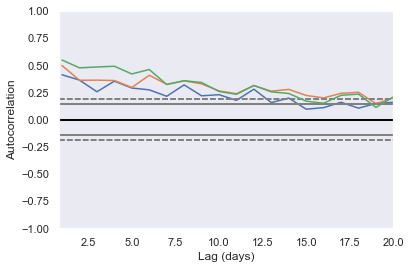

In [42]:
# Not the best plotting method

autocorrelation_plot(df_tweet_GME_dailymean['Positive Tweet Score'])
plt.xlabel('Lag (days)');
# plt.axvline(31, color = 'green')

autocorrelation_plot(df_tweet_GME_dailymean['Negative Tweet Score'])
plt.xlabel('Lag (days)');

autocorrelation_plot(df_tweet_GME_dailymean['Compound Tweet Score'])
plt.xlabel('Lag (days)');

plt.xlim([.8,20])

In [22]:
from statsmodels.tsa.stattools import acf


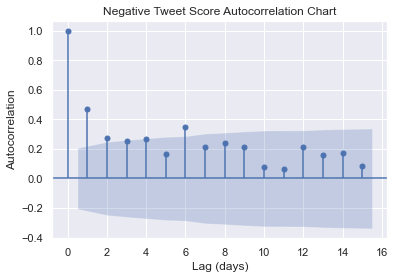

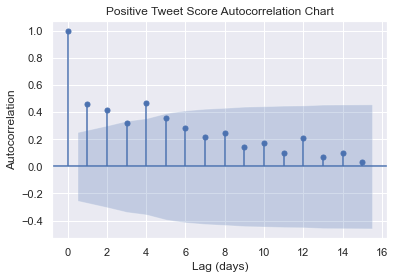

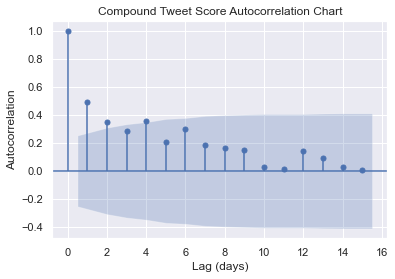

In [77]:
import statsmodels.api as sm

# STATISITCALLY SIGNIFICANT

sm.graphics.tsa.plot_acf(df_tweet_GME_dailymean['Negative Tweet Score'].loc[:'2021-3-31'], lags=15, alpha=.05)
plt.xlabel('Lag (days)')
plt.ylabel('Autocorrelation')
plt.title('Negative Tweet Score Autocorrelation Chart');

sm.graphics.tsa.plot_acf(df_tweet_GME_dailymean['Positive Tweet Score'].loc[:'2021-3-1'], lags=15, alpha=.05)
plt.xlabel('Lag (days)')
plt.ylabel('Autocorrelation')
plt.title('Positive Tweet Score Autocorrelation Chart');

sm.graphics.tsa.plot_acf(df_tweet_GME_dailymean['Compound Tweet Score'].loc[:'2021-3-1'], lags=15, alpha=.05)
plt.xlabel('Lag (days)')
plt.ylabel('Autocorrelation')
plt.title('Compound Tweet Score Autocorrelation Chart');

In [ ]:
sm.graphics.tsa.plot_acf(df_tweet_GME_dailymean['Negative Tweet Score'].loc[:'2021-4-30'], lags=15, alpha=.05)
plt.xlabel('Lag (days)')
plt.ylabel('Autocorrelation')
plt.title('Negative Tweet Score Autocorrelation Chart');

sm.graphics.tsa.plot_acf(df_tweet_GME_dailymean['Positive Tweet Score'].loc[:'2021-4-30'], lags=15, alpha=.05)
plt.xlabel('Lag (days)')
plt.ylabel('Autocorrelation')
plt.title('Positive Tweet Score Autocorrelation Chart');

sm.graphics.tsa.plot_acf(df_tweet_GME_dailymean['Compound Tweet Score'].loc[:'2021-4-30'], lags=15, alpha=.05)
plt.xlabel('Lag (days)')
plt.ylabel('Autocorrelation')
plt.title('Compound Tweet Score Autocorrelation Chart');

In [60]:
df_tweet_GME_dailymean

,Retweet Count,Likes Count,Reply Count,Positive Tweet Score,Negative Tweet Score,Neutral Tweet Score,Compound Tweet Score,Compound Followers
Datetime,,,,,,,,
2021-01-01,0.949696,10.635733,1.125759,0.160056,0.062647,0.777298,0.269853,3.436436e+04
2021-01-02,68.192742,57.750000,3.098387,0.161263,0.052595,0.786141,0.327639,4.424941e+04
2021-01-03,1.685695,25.027535,2.658831,0.156467,0.064760,0.778779,0.273965,2.599319e+04
2021-01-04,1.246163,15.107438,2.065525,0.149979,0.058672,0.791347,0.258476,4.053196e+04
2021-01-05,0.873913,9.100870,0.984348,0.162212,0.057242,0.780561,0.313195,8.266200e+03
2021-01-06,1.461128,13.621958,1.153709,0.150668,0.094247,0.755075,0.175234,6.899461e+03
2021-01-07,2.293073,28.019982,6.027087,0.152779,0.085045,0.762185,0.209455,3.150429e+04
2021-01-08,0.722526,9.587767,1.551964,0.149320,0.072912,0.777754,0.244209,1.157453e+04
2021-01-09,0.254505,4.972973,1.345345,0.153336,0.077223,0.769426,0.241861,1.353479e+04


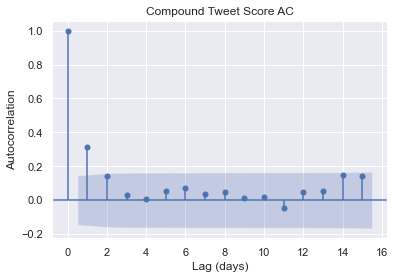

In [54]:
# MAYBE Statistically Significant

sm.graphics.tsa.plot_acf(df_tweet_GME_dailymean['Neutral Tweet Score'], lags=15, alpha=.05)
plt.xlabel('Lag (days)')
plt.ylabel('Autocorrelation')
plt.title('Compound Tweet Score AC');

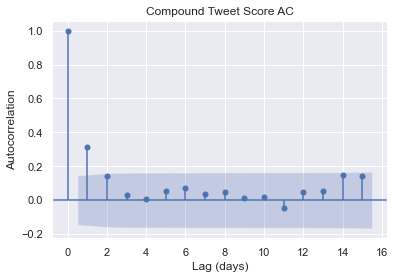

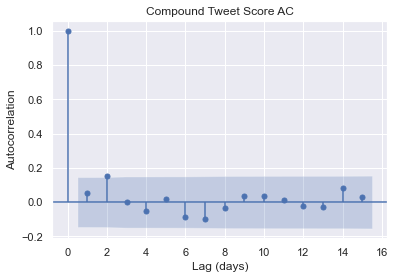

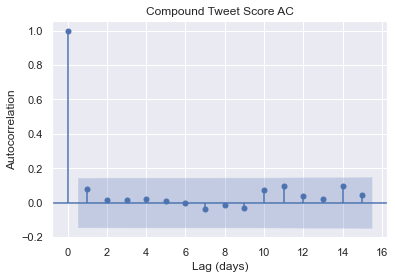

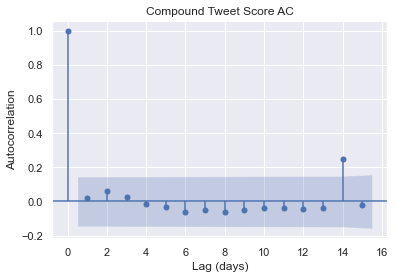

In [52]:
# Statistically INSIGNIFICANT

# sm.graphics.tsa.plot_acf(df_tweet_GME_dailymean['Compound Followers'], lags=15, alpha=.05)
# plt.xlabel('Lag (days)')
# plt.ylabel('Autocorrelation')
# plt.title('Compound Tweet Score AC');

sm.graphics.tsa.plot_acf(df_tweet_GME_dailymean['Reply Count'], lags=15, alpha=.05)
plt.xlabel('Lag (days)')
plt.ylabel('Autocorrelation')
plt.title('Compound Tweet Score AC');

sm.graphics.tsa.plot_acf(df_tweet_GME_dailymean['Likes Count'], lags=15, alpha=.05)
plt.xlabel('Lag (days)')
plt.ylabel('Autocorrelation')
plt.title('Compound Tweet Score AC');

sm.graphics.tsa.plot_acf(df_tweet_GME_dailymean['Retweet Count'], lags=15, alpha=.05)
plt.xlabel('Lag (days)')
plt.ylabel('Autocorrelation')
plt.title('Compound Tweet Score AC');

# Stock Data

## GME

In [179]:
df_stock_gme = getStockData('GME','2021-01-01','2021-06-30')

[*********************100%***********************]  1 of 1 completed


In [180]:
df_stock_gme

,Open,High,Low,Close,Adj Close,Volume,Closing Differences,Percent Change
Datetime,,,,,,,,
2021-01-04,19.000000,19.100000,17.150000,17.250000,17.250000,10022500,NaN,-9.210526
2021-01-05,17.350000,18.080000,17.230000,17.370001,17.370001,4961500,0.120001,0.115276
2021-01-06,17.340000,18.980000,17.330000,18.360001,18.360001,6056200,0.990000,5.882356
2021-01-07,18.469999,19.450001,18.020000,18.080000,18.080000,6129300,-0.280001,-2.111529
2021-01-08,18.180000,18.299999,17.080000,17.690001,17.690001,6482000,-0.389999,-2.695268
2021-01-11,19.410000,20.650000,19.010000,19.940001,19.940001,14908000,2.250000,2.730555
2021-01-12,19.959999,20.400000,19.320000,19.950001,19.950001,7060700,0.010000,-0.050092
2021-01-13,20.420000,38.650002,20.030001,31.400000,31.400000,144501700,11.449999,53.770810
2021-01-14,38.090000,43.060001,33.049999,39.910000,39.910000,93717400,8.510000,4.778156


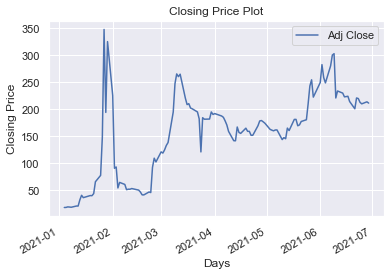

In [405]:
# Plot

df_stock_gme[['Adj Close']].plot()

# plt.ylim(-120, 120)

plt.xlabel('Days')
plt.ylabel('Closing Price')
plt.title('Closing Price Plot');

## AAPL

In [89]:
df_stock_aapl = getStockData('AAPL', '2021-01-01', '2021-03-01')

[*********************100%***********************]  1 of 1 completed


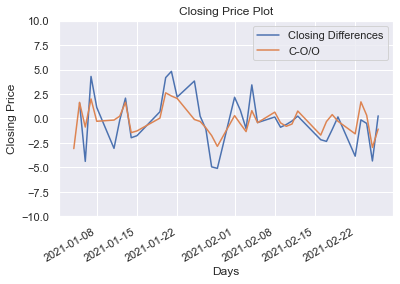

In [96]:
# Plot

df_stock_aapl[['Closing Differences', 'C-O/O']].plot()

plt.ylim(-10, 10)

plt.xlabel('Days')
plt.ylabel('Closing Price')
plt.title('Closing Price Plot');

# Merging Twitter + Stock DataFrames

## GME

In [182]:
# Why is there NaN values for Volume and closing differences?
# Because the stock market is only opened on business days!
# So we dropped NaN values

df_merged_gme = df_stock_gme.merge(df_tweet_GME_dailymean, how='right', left_index=True, right_index=True)

In [183]:
df_merged_gme_nonull = df_merged_gme.dropna()

In [184]:
df_merged_gme_nonull['Percent Change Trend'] = df_merged_gme_nonull['Percent Change'].apply(lambda x: 'Negative_Trend' if x<0 else 'Positive_Trend')
df_merged_gme_nonull['Closing Differences Trend'] = df_merged_gme_nonull['Closing Differences'].apply(lambda x: 'Negative_Trend' if x<0 else 'Positive_Trend')

C:\Users\Daanish\AppData\Local\Temp/ipykernel_1480/4174700304.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_merged_gme_nonull['Percent Change Trend'] = df_merged_gme_nonull['Percent Change'].apply(lambda x: 'Negative_Trend' if x<0 else 'Positive_Trend')
C:\Users\Daanish\AppData\Local\Temp/ipykernel_1480/4174700304.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_merged_gme_nonull['Closing Differences Trend'] = df_merged_gme_nonull['Closing Differences'].apply(lambda x: 'Negative_Trend' if x<0

In [102]:
# df_merged_gme = df_merged_gme[['Volume', 'Closing Differences', 'Percent Change', 'Tweet Id', 'Followers Count', 'Retweet Count',
#                  'Likes Count', 'Reply Count', 'Positive Tweet Score', 'Neutral Tweet Score','Negative Tweet Score', 'Compound Tweet Score',
#                   'Compound Followers', 'Percent Change Trend', 'Closing Price Trend']]

KeyError: "['Tweet Id', 'Followers Count', 'Percent Change Trend', 'Closing Price Trend'] not in index"

In [105]:
# Interpolate NaN values (weekend values)
df_merged_gme[['Volume', 'Closing Differences', 'Percent Change']] = df_merged_gme[['Volume',
                                                                                    'Closing Differences',
                                                                                    'Percent Change']].interpolate(method='linear',
                                                                                                                   limit_direction='both',
                                                                                                                   axis=0)

In [115]:
df_merged_gme.to_pickle('df_merged_gme_jan2021-jun2021.pkl')

In [185]:
df_merged_gme_nonull.value_counts('Closing Differences Trend')

Closing Differences Trend
Negative_Trend    61
Positive_Trend    61
dtype: int64

In [186]:
# print(df_merged_gme.value_counts('Polarity Categories'))
df_merged_gme_nonull.value_counts('Percent Change Trend')

Percent Change Trend
Negative_Trend    68
Positive_Trend    54
dtype: int64

In [188]:
df_merged_gme_nonull['PCT Label 3days ahead'] = df_merged_gme_nonull['Percent Change Trend'].shift(-3)
df_merged_gme_nonull['CPT Label 3days ahead'] = df_merged_gme_nonull['Closing Differences Trend'].shift(-3)

C:\Users\Daanish\AppData\Local\Temp/ipykernel_1480/1224617130.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_merged_gme_nonull['PCT Label 3days ahead'] = df_merged_gme_nonull['Percent Change Trend'].shift(-3)
C:\Users\Daanish\AppData\Local\Temp/ipykernel_1480/1224617130.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_merged_gme_nonull['CPT Label 3days ahead'] = df_merged_gme_nonull['Closing Differences Trend'].shift(-3)


In [190]:
df_merged_gme_nonull['PCT Label 1day ahead'] = df_merged_gme_nonull['Percent Change Trend'].shift(-1)
df_merged_gme_nonull['CPT Label 1day ahead'] = df_merged_gme_nonull['Closing Differences Trend'].shift(-1)

C:\Users\Daanish\AppData\Local\Temp/ipykernel_1480/2515639781.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_merged_gme_nonull['PCT Label 1day ahead'] = df_merged_gme_nonull['Percent Change Trend'].shift(-1)
C:\Users\Daanish\AppData\Local\Temp/ipykernel_1480/2515639781.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_merged_gme_nonull['CPT Label 1day ahead'] = df_merged_gme_nonull['Closing Differences Trend'].shift(-1)


In [195]:
df_merged_gme_nonull.value_counts('CPT Label 3days ahead')

CPT Label 3days ahead
Negative_Trend    60
Positive_Trend    59
dtype: int64

In [194]:
df_merged_gme_nonull.value_counts('CPT Label 1day ahead')

CPT Label 1day ahead
Negative_Trend    61
Positive_Trend    60
dtype: int64

In [124]:
df_merged_gme_nonull=df_merged_gme_nonull.dropna()

# Dealing with Imbalances

In [34]:
from imblearn.over_sampling import SMOTE

In [35]:
sampler = SMOTE(random_state=42)

In [ ]:
# from imblearn.over_sampling import SMOTE
# sm = SMOTE(random_state=42)
# X_res, y_res = sm.fit_resample(X_train, y_train)

# Modeling

## GME

#### Train/Test Split

In [218]:
X_testing_train = df_merged_gme_nonull.loc[:'2021-5-23'][relevant_columns]
y_testing_train = df_merged_gme_nonull.loc[:'2021-5-23']['CPT Label 1day ahead']

X_testing_test = df_merged_gme_nonull.loc['2021-5-24':][relevant_columns]
y_testing_test = df_merged_gme_nonull.loc['2021-5-24':]['CPT Label 1day ahead']

In [216]:
X = df_merged_gme_nonull
y = df_merged_gme_nonull['CPT Label 3days ahead']

In [212]:
relevant_columns = ['Retweet Count', 'Likes Count', 'Reply Count',
                                  'Positive Tweet Score', 'Negative Tweet Score', 'Neutral Tweet Score',
                                  'Compound Followers', 'Volume']

In [223]:
X_train = X.loc[:'2021-5-23']
X_test  = X.loc['2021-5-24':]

y_train = y.loc[:'2021-5-23']
y_test = y.loc['2021-5-24':]

In [228]:
X_train = pd.read_pickle('C:/Users/Daanish/Desktop/capstone_project/project_environment/pickles/latest_GME_demo/X_1-1--5-21_TRAIN.pkl')
X_test = pd.read_pickle('C:/Users/Daanish/Desktop/capstone_project/project_environment/pickles/latest_GME_demo/X_5-24--6-24_NEW.pkl')

y_train = pd.read_pickle('C:/Users/Daanish/Desktop/capstone_project/project_environment/pickles/latest_GME_demo/y_1-1--5-21_TRAIN_CPT-3.pkl')
y_test = pd.read_pickle('C:/Users/Daanish/Desktop/capstone_project/project_environment/pickles/latest_GME_demo/y_5-24--6-24_NEW_CPT-3.pkl')

In [207]:
# X_train.to_pickle('X_1-1--5-21_TRAIN.pkl')
# X_test.to_pickle('X_5-24--6-24_NEW.pkl')
# y_train.to_pickle('y_1-1--5-21_TRAIN_CPT-3.pkl')
# y_test.to_pickle('y_5-24--6-24_NEW_CPT-3.pkl')

#### Random Forest Classifier (Baseline)

In [202]:
X_train.columns

Index(['Retweet Count', 'Likes Count', 'Reply Count', 'Positive Tweet Score',
       'Negative Tweet Score', 'Neutral Tweet Score', 'Compound Followers',
       'Volume'],
      dtype='object')

In [259]:
transformer_rfc = ColumnTransformer([
    ('scaler', StandardScaler(), ['Retweet Count', 'Likes Count', 'Reply Count',
                                  'Positive Tweet Score', 'Negative Tweet Score', 'Neutral Tweet Score',
                                  'Compound Followers', 'Volume'])
    
])

In [260]:
pipe_rfc = Pipeline([
    ('ohe scaler', transformer_rfc),
    ('randomforest', RandomForestClassifier(n_estimators=5000))
])

In [261]:
pipe_rfc_fit = pipe_rfc.fit(X_train, y_train)

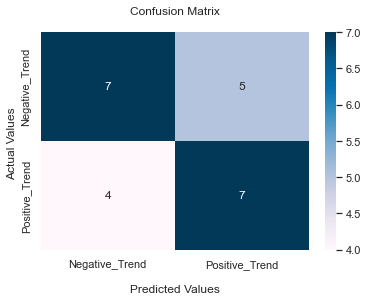

In [262]:
cf = confusion_matrix(y_true=y_test, y_pred=pipe_rfc_fit.predict(X_test))
ax = sns.heatmap(cf, annot=True, cmap='PuBu')

ax.set_title('Confusion Matrix\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['Negative_Trend','Positive_Trend'])
ax.yaxis.set_ticklabels(['Negative_Trend','Positive_Trend'])

## Display the visualization of the Confusion Matrix.
plt.show()

In [263]:
model_evaluation(pipe_rfc_fit, X_test, y_test, positive_label='Positive_Trend')

{'accuracy': 0.6087,
 'precision': 0.5833,
 'recall': 0.6364,
 'area under precision-recall curve': 0.6525,
 'f1 score': 0.6087}

In [264]:
pipe_path = 'C:/Users/Daanish/Desktop/capstone_project/project_environment/pickles/latest_GME_demo/pipe_rfc_fit_jan-may_PCT3daylag.pkl'
pipe = pickle.load(open(pipe_path, 'rb'))

In [111]:
pickle.dump(pipe_rfc_fit, open('pipe_rfc_fit_jan-may_PCT3daylag.pkl', 'wb'))

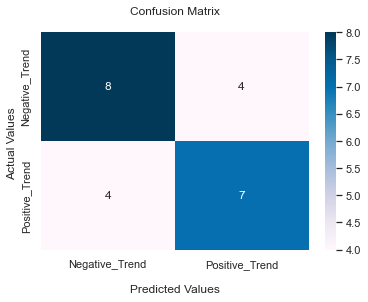

In [268]:
cf = confusion_matrix(y_true=y_test, y_pred=pipe.predict(X_test))
ax = sns.heatmap(cf, annot=True, cmap='PuBu')

ax.set_title('Confusion Matrix\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['Negative_Trend','Positive_Trend'])
ax.yaxis.set_ticklabels(['Negative_Trend','Positive_Trend'])

## Display the visualization of the Confusion Matrix.
plt.show()

In [269]:
model_evaluation(pipe, X_test, y_test, positive_label='Positive_Trend')

{'accuracy': 0.6521739,
 'precision': 0.6363636,
 'recall': 0.6363636,
 'area under precision-recall curve': 0.6515008,
 'f1 score': 0.6363636}

In [152]:
def avg_scores(pipeline, iterations, X_tr, y_tr, X_te, y_te):
    precision_scores = []
    recall_scores = []
    accuracy_scores = []
    f1_scores = []
    auc_pc = []
    
    for i in range(iterations):
        pipe_fit = pipeline.fit(X_tr, y_tr)
        precision_scores.append(model_evaluation(pipe_fit, X_te, y_te, positive_label='Positive_Trend')['precision'])
        recall_scores.append(model_evaluation(pipe_fit, X_te, y_te, positive_label='Positive_Trend')['recall'])
        accuracy_scores.append(model_evaluation(pipe_fit, X_te, y_te, positive_label='Positive_Trend')['accuracy'])
        auc_pc.append(model_evaluation(pipe_fit, X_te, y_te, positive_label='Positive_Trend')['area under precision-recall curve'])
        f1_scores.append(model_evaluation(pipe_fit, X_te, y_te, positive_label='Positive_Trend')['f1 score'])
    
    dict_ = {}
    dict_['precision avg'] = np.array(precision_scores).mean()
    dict_['recall avg'] = np.array(recall_scores).mean()
    dict_['accuracy avg'] = np.array(accuracy_scores).mean()
    dict_['area under precision-recall curve avg'] = np.array(auc_pc).mean()
    dict_['f1 score avg'] = np.array(f1_scores).mean()
    
    return print(dict_)

In [155]:
# avg scores on 500 fits
avg_scores(pipeline=pipe_rfc, iterations=500, X_tr=X_train, y_tr=y_train, X_te=X_test, y_te=y_test)

{'precision avg': 0.5860152000000001, 'recall avg': 0.7223913999999998, 'accuracy avg': 0.620793, 'area under precision-recall curve avg': 0.6510536, 'f1 score avg': 0.6463715999999999}


In [172]:
# avg scores on 5000 fits n_est=100
avg_scores(pipeline=pipe_rfc, iterations=5000, X_tr=X_train, y_tr=y_train, X_te=X_test, y_te=y_test)

{'precision avg': 0.5825773599999999, 'recall avg': 0.69292146, 'accuracy avg': 0.60972668, 'area under precision-recall curve avg': 0.62770508, 'f1 score avg': 0.62944568}


In [171]:
# avg scores on 100 fits n_est=100
avg_scores(pipeline=pipe_rfc, iterations=100, X_tr=X_train, y_tr=y_train, X_te=X_test, y_te=y_test)

{'precision avg': 0.5849319999999999, 'recall avg': 0.7018479999999998, 'accuracy avg': 0.611312, 'area under precision-recall curve avg': 0.626614, 'f1 score avg': 0.6344420000000001}


In [154]:
# avg scores on 100 fits n_est = 5000
avg_scores(pipeline=pipe_rfc, iterations=100, X_tr=X_train, y_tr=y_train, X_te=X_test, y_te=y_test)

{'precision avg': 0.5800989999999999, 'recall avg': 0.7163919999999997, 'accuracy avg': 0.6139199999999999, 'area under precision-recall curve avg': 0.647346, 'f1 score avg': 0.6402549999999999}


In [153]:
# avg scores on 10 fits 
avg_scores(pipeline=pipe_rfc, iterations=10, X_tr=X_train, y_tr=y_train, X_te=X_test, y_te=y_test)

{'precision avg': 0.5588899999999999, 'recall avg': 0.7182099999999998, 'accuracy avg': 0.5913, 'area under precision-recall curve avg': 0.6425799999999999, 'f1 score avg': 0.6278900000000001}


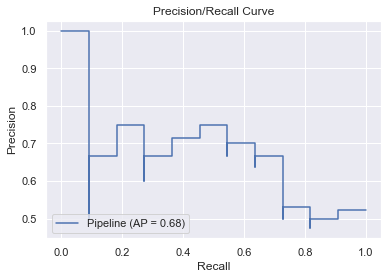

In [157]:
# 3 day shift on labels

PrecisionRecallDisplay.from_estimator(pipe_rfc_fit, X_test, y_test)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision/Recall Curve');

# Experimenting with results 

In [ ]:
# FIX THE EXPERIMENT CALCULATIONS!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

In [282]:
predictions = pipe.predict(X_test)

In [317]:
df_stock_gme_pred = df_stock_gme.loc['2021-5-24':'2021-6-24']

In [318]:
df_stock_gme_pred.loc[:, 'preds shift +3'] = predictions

C:\Users\Daanish\anaconda3\envs\capstone_environment\lib\site-packages\pandas\core\indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


In [320]:
df_stock_gme_pred.loc[:,'buy/sell preds'] = df_stock_gme_pred['preds shift +3'].apply(lambda x: 1 if x == 'Positive_Trend' else -1)

C:\Users\Daanish\anaconda3\envs\capstone_environment\lib\site-packages\pandas\core\indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


In [322]:
df_stock_gme_pred['buy/sell preds +2'] = df_stock_gme_pred['buy/sell preds'].shift(2)

C:\Users\Daanish\AppData\Local\Temp/ipykernel_1480/2418782273.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_stock_gme_pred['buy/sell preds +2'] = df_stock_gme_pred['buy/sell preds'].shift(2)


In [323]:
df_stock_gme_pred = df_stock_gme_pred.dropna()

In [324]:
df_stock_gme_pred['predictive gain/loss'] = (df_stock_gme_pred['Adj Close']-df_stock_gme_pred['Open'])*df_stock_gme_pred['buy/sell preds +2']

C:\Users\Daanish\AppData\Local\Temp/ipykernel_1480/1600073876.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_stock_gme_pred['predictive gain/loss'] = (df_stock_gme_pred['Adj Close']-df_stock_gme_pred['Open'])*df_stock_gme_pred['buy/sell preds +2']


In [326]:
df_stock_gme_pred

,Open,High,Low,Close,Adj Close,Volume,Closing Differences,Percent Change,preds shift +3,buy/sell preds,buy/sell preds +2,predictive gain/loss
Datetime,,,,,,,,,,,,
2021-05-26,229.000000,248.479996,225.550003,242.559998,242.559998,21119900,33.130005,5.921396,Positive_Trend,1,1.0,13.559998
2021-05-27,229.800003,264.000000,227.000000,254.130005,254.130005,15526300,11.570007,10.587468,Positive_Trend,1,-1.0,-24.330002
2021-05-28,262.970001,268.799988,221.429993,222.000000,222.000000,11751400,-32.130005,-15.579724,Positive_Trend,1,1.0,-40.970001
2021-06-01,233.479996,254.979996,227.070007,249.020004,249.020004,9625600,27.020004,6.655820,Negative_Trend,-1,1.0,15.540009
2021-06-02,248.880005,294.000000,244.300003,282.239990,282.239990,16019200,33.219986,13.404044,Negative_Trend,-1,1.0,33.359985
2021-06-03,265.709991,274.429993,242.119995,258.179993,258.179993,8000000,-24.059998,-2.833916,Negative_Trend,-1,-1.0,7.529999
2021-06-04,256.019989,265.000000,245.770004,248.360001,248.360001,3637500,-9.819992,-2.991949,Positive_Trend,1,-1.0,7.659988
2021-06-07,258.000000,282.000000,255.199997,280.010010,280.010010,6051500,31.650009,8.531012,Positive_Trend,1,-1.0,-22.010010
2021-06-08,292.000000,344.660004,281.000000,300.000000,300.000000,17439100,19.989990,2.739726,Negative_Trend,-1,1.0,8.000000


In [327]:
first_day_closing = df_stock_gme_pred.loc['2021-5-26']['Adj Close']

In [329]:
df_stock_gme_pred.at['2021-5-26', 'pred experiment results'] = first_day_closing

C:\Users\Daanish\anaconda3\envs\capstone_environment\lib\site-packages\pandas\core\indexing.py:1684: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = infer_fill_value(value)
C:\Users\Daanish\anaconda3\envs\capstone_environment\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


In [364]:
df_stock_gme_pred = df_stock_gme_pred.reset_index()

In [366]:
for i in range(1,len(df_stock_gme_pred)):
    df_stock_gme_pred.loc[i, 'pred experiment results'] = df_stock_gme_pred.loc[i-1, 'pred experiment results'] + df_stock_gme_pred.loc[i, 'predictive gain/loss']

In [376]:
df_stock_gme_pred = df_stock_gme_pred.set_index('Datetime')

In [402]:
df_stock_gme_pred.to_pickle('df_gme_prediction_exp.pkl')

In [9]:
path = 'C:/Users/Daanish/Desktop/capstone_project/project_environment/df_gme_prediction_exp_1.pkl'
df_experiment = pd.read_pickle(path)

In [118]:
df_experiment

,Open,High,Low,Close,Adj Close,Volume,Closing Differences,Percent Change,preds shift +3,buy/sell preds,buy/sell preds +2,predictive gain/loss,pred experiment results
Datetime,,,,,,,,,,,,,
2021-05-26,229.000000,248.479996,225.550003,242.559998,242.559998,21119900,33.130005,5.921396,Positive_Trend,1,1.0,13.559998,242.559998
2021-05-27,229.800003,264.000000,227.000000,254.130005,254.130005,15526300,11.570007,10.587468,Positive_Trend,1,-1.0,-24.330002,218.229996
2021-05-28,262.970001,268.799988,221.429993,222.000000,222.000000,11751400,-32.130005,-15.579724,Positive_Trend,1,1.0,-40.970001,177.259995
2021-06-01,233.479996,254.979996,227.070007,249.020004,249.020004,9625600,27.020004,6.655820,Negative_Trend,-1,1.0,15.540009,192.800003
2021-06-02,248.880005,294.000000,244.300003,282.239990,282.239990,16019200,33.219986,13.404044,Negative_Trend,-1,1.0,33.359985,226.159988
2021-06-03,265.709991,274.429993,242.119995,258.179993,258.179993,8000000,-24.059998,-2.833916,Negative_Trend,-1,-1.0,7.529999,233.689987
2021-06-04,256.019989,265.000000,245.770004,248.360001,248.360001,3637500,-9.819992,-2.991949,Positive_Trend,1,-1.0,7.659988,241.349976
2021-06-07,258.000000,282.000000,255.199997,280.010010,280.010010,6051500,31.650009,8.531012,Positive_Trend,1,-1.0,-22.010010,219.339966
2021-06-08,292.000000,344.660004,281.000000,300.000000,300.000000,17439100,19.989990,2.739726,Negative_Trend,-1,1.0,8.000000,227.339966


In [11]:
# Series of predictions that predict the NEXT DAY trend

prediction_series = df_experiment['buy/sell preds +2']
open_series = df_experiment['Open']
close_series = df_experiment['Adj Close']

In [177]:
def graph_algorithm_model(df):
    prediction_series_ = df['buy/sell preds +2']
    open_series_ = df['Open']
    close_series_ = df['Adj Close']    
    stock_hold = True
    
    iterable = []
    for pred, open__, close__ in zip(prediction_series, open_series_, close_series_):
        iterable.append((pred, open__, close__))     
    
    holding = 350
    close_previous = iterable[0][2] # previous day hold price if stock is held 
    open_previous = iterable[0][1] # opening price of first day 
    
    final_list = []
    final_list.append(holding + (close_previous-open_previous))
    holding = holding + (close_previous-open_previous)
    
    for i, e in enumerate(iterable):
        if stock_hold == True:
            if e[0] == -1.0:
                holding = holding + (iterable[i+1][2] - close_previous) # update holdings for end of day price
                final_list.append(holding) # append updated hold value onto list
                stock_hold = False # sell stock
                close_previous = iterable[i+1][2] # update previously used close price
                continue

            elif e[0] == 1.0:
                holding = holding + (iterable[i+1][2] - close_previous) 
                final_list.append(holding)
                close_previous = iterable[i+1][2] # update previously used close price
                continue
    
        if stock_hold == False:
            if e[0] == -1.0:
                # hold price stays the same
                # not updating previous close price
                final_list.append(holding) # append same hold value onto list
                continue

            elif e[0] == 1.0:
                stock_hold = True # buy stock AT OPENING PRICE
                holding = holding + (iterable[i+1][2] - iterable[i+1][1]) # Profits (if correct) or losses are from the difference between close and open price
                final_list.append(holding)
                close_previous = iterable[i+1][2]
                continue        
    model_outcome = pd.DataFrame(data=final_list, columns=['model_outcome'])[:21]  
    model_outcome.index = prediction_series_.index
    return model_outcome
        

def graph_algorithm_base(df):
    open_series_ = df['Open']
    close_series_ = df['Adj Close']    
    
    iterable = []
    for open__, close__ in zip(open_series_, close_series_):
        iterable.append((open__, close__))     
    
    holding = 350
    close_previous = iterable[0][1] # previous day hold price if stock is held 
    open_previous = iterable[0][0] # opening price of first day 
    
    final_list = []
    final_list.append(holding + (close_previous-open_previous))
    holding = holding + (close_previous-open_previous)
    
    try:
        for i, e in enumerate(iterable):
            holding = holding + (iterable[i+1][1] - close_previous) # update holdings for end of day price
            final_list.append(holding) # append updated hold value onto list
            close_previous = iterable[i+1][1] # update previously used close price
    
    except IndexError:
    
        buy_hold_outcome = pd.DataFrame(data=final_list, columns=['buy_hold_outcome'])
        buy_hold_outcome.index = open_series_.index
        return buy_hold_outcome

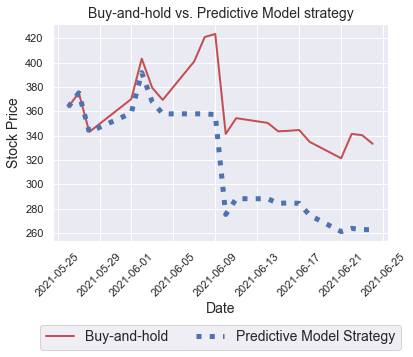

In [179]:
base_results = graph_algorithm_base(df_experiment)
pred_results = graph_algorithm_model(df_experiment)

plt.plot(base_results, 'r',  linewidth=2)
plt.plot(pred_results,  'b',  linestyle=':', linewidth=5)

plt.xlabel('Date', fontsize=14)
plt.xticks(rotation = 45)
plt.ylabel('Stock Price', fontsize=14)

a, b = 'Buy-and-hold', 'Predictive Model Strategy'
plt.legend((a,b), fontsize=14, loc='upper center', bbox_to_anchor=(0.5, -0.35), ncol=2, frameon=True)
plt.title('Buy-and-hold vs. Predictive Model strategy', fontsize=14)

plt.show()

# TSLA

In [18]:
df_tweet_TSLA_list = []
for i in glob.glob('tweets_TSLA/TSLA_jan2021/*')+glob.glob('tweets_TSLA/TSLA_feb2021/*')+glob.glob('tweets_TSLA/TSLA_mar2021/*'):
    df_tweet_TSLA_list.append(pd.read_csv(i))

In [19]:
len(df_tweet_TSLA_list)

8100

In [20]:
df_tweet_TSLA = dataWrangle_multiple(df_tweet_TSLA_list)

In [21]:
df_tweet_TSLA

,Tweet Id,Text,Username,Followers Count,Retweet Count,Likes Count,Reply Count
Datetime,,,,,,,
2021-01-01,1345157813224390656,Join Robinhood with my link and we'll both get...,SUPER_Kent_trad,231,0,1,0
2021-01-01,1345156534884577281,Short selling is very risky and those w/ sizab...,ChrisBloomstran,63640,0,48,1
2021-01-01,1345156541524140036,Borrowing against Tesla (or any) shares and bu...,ChrisBloomstran,63640,1,62,3
2021-01-01,1345153312702791681,@seaslugs8 Gonna back the Tesla implant once i...,nyanberryy,2694,0,1,0
2021-01-01,1345153573689155584,I always thought the most obnoxious people on ...,alifarhat79,96059,10,119,10
...,...,...,...,...,...,...,...
2021-03-31,1377408083584983046,@elonmusk would you mind helping this kid out ?,MayeIrun,32,0,0,0
2021-03-31,1377408072600018944,@elonmusk lemme see sum real quick,YourGirlLiss,1224,0,0,0
2021-03-31,1377408066954559489,@elonmusk hi! so after years of begging my dad...,ryleekouri,0,0,0,0


In [26]:
pd.set_option("display.max_rows", 90)

In [1]:
df_tweet_TSLA.value_counts('Datetime').sort_index()

NameError: name 'df_tweet_TSLA' is not defined